# Corpus Analysis

In [1]:
import string
import re
import spacy 
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

#To Temporarily Remove Deprecation Warning
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/CAMPUS/jrab2017/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Reading the Data File

In [2]:
data = pd.read_csv('/raid/tft-data/data/combined_news.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


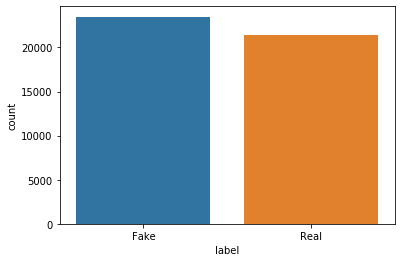

In [3]:
sns.countplot(data['label'])

count    44898.000000
mean       415.760412
std        361.648003
min          1.000000
25%        208.000000
50%        371.000000
75%        525.000000
max       8436.000000
Name: length, dtype: float64

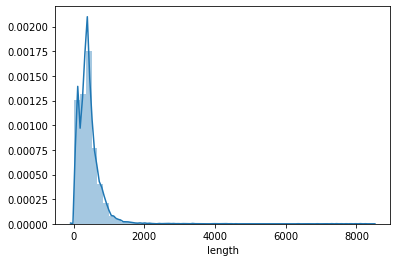

In [4]:
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))
sns.distplot(data['length'])
data['length'].describe()

## Preparing the Data 

In [5]:
# main tokenizing function
def tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):
    # removing unwanted characters and numbers from the string
    pattern = '[' + '|'.join(list(chars_to_exclude)) + '|\d]*'
    line = re.sub(pattern, "", line).lower()

    # generating tokens
    tokens = [token for token in tokenizer.tokenize(line) if token not in stopwords]
    
    # stemming the tokens if the user wants to
    if stem_tokens:
        tokens = [stemmer.stem(token) for token in tokens]

    # lemmatizing the tokens if the user wants to
    if lemm_tokens:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [6]:
# function to help with tokenizing columns
def tokenize_lines(lines, chars_to_exclude, stopwords, tokenizer=None, stem_tokens=False, stemmer=None, lemm_tokens=False, lemmatizer=None):

    all_tokens = [tokenize_line(line, chars_to_exclude, stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer) for line in lines]

    return np.array(all_tokens)

In [7]:
# the default parameters for now
def get_default_tokenization_params():
    chars_to_exclude = string.punctuation
    english_stopwords = set(stopwords.words('english'))
    tokenizer = RegexpTokenizer("\w+")

    #Modify these according to the user's choices
    stem_tokens = False
    stemmer = PorterStemmer()

    lemm_tokens = True
    lemmatizer = WordNetLemmatizer()

    return (chars_to_exclude, english_stopwords, tokenizer, stem_tokens, stemmer, lemm_tokens, lemmatizer)

In [8]:
X = tokenize_lines(data['text'], *get_default_tokenization_params())
Y = data['label']
data_processed = pd.DataFrame(({'title': data['title'], 'text': X, 'label': Y}))

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


# Performing Topic Modeling using LDA 

In [9]:
# Import all necessary libraries
# Gensim library for additional topic modeling and statistical anlysis
# Corpora module implements dictionary-mapping between words and corresponding integer IDs
import gensim
import pickle
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation

html_dir = '~/Project/cs152sp21-project/Corpus Analysis/htmls/'
num_topics = 10 
num_features = 100

## Real News 

### Creating the Model

In [10]:
real_news = data_processed[data_processed['label'] == 'Real']
real_text= real_news['text']
real_gensim_dictionary = corpora.Dictionary(real_text)

#creating bag of words (bow) w/ real_text
real_gensim_corpus = [real_gensim_dictionary.doc2bow(token, allow_update=True) for token in real_text]

#saving dictionary and bow (via pickle )to use for predictions below
real_corpus_file = 'real_gensim_corpus.pkl'
pickle.dump(real_gensim_corpus, open(real_corpus_file, 'wb'))
real_gensim_dictionary.save('real_gensim_dictionary.gensim')

In [11]:
real_lda_model = gensim.models.ldamodel.LdaModel(real_gensim_corpus, num_topics=num_topics, id2word=real_gensim_dictionary, passes=10)
real_lda_model.save('real_gensim_model.gensim')

In [12]:
#Print 5 words per topic
topics = real_lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.025*"said" + 0.017*"state" + 0.016*"u" + 0.010*"united" + 0.009*"iran"')
(1, '0.022*"said" + 0.009*"oil" + 0.008*"u" + 0.008*"hurricane" + 0.007*"million"')
(2, '0.029*"china" + 0.020*"said" + 0.019*"u" + 0.013*"trump" + 0.013*"trade"')
(3, '0.018*"tax" + 0.014*"percent" + 0.014*"said" + 0.012*"would" + 0.012*"year"')
(4, '0.028*"republican" + 0.021*"vote" + 0.020*"house" + 0.020*"said" + 0.019*"senate"')
(5, '0.039*"trump" + 0.019*"said" + 0.011*"president" + 0.011*"republican" + 0.010*"clinton"')
(6, '0.018*"party" + 0.018*"said" + 0.011*"government" + 0.011*"minister" + 0.010*"eu"')
(7, '0.032*"court" + 0.017*"state" + 0.016*"said" + 0.015*"law" + 0.011*"case"')
(8, '0.025*"said" + 0.010*"people" + 0.008*"police" + 0.008*"reuters" + 0.007*"year"')
(9, '0.025*"said" + 0.011*"u" + 0.010*"investigation" + 0.009*"reuters" + 0.009*"official"')


### Evaluation and Visualization

In [13]:
coherence_score_lda = CoherenceModel(model=real_lda_model, texts=real_text, dictionary=real_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', real_lda_model.log_perplexity(real_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -8.181132448372187

Coherence Score: 0.46556699653055683


In [14]:
real_gensim_dictionary = gensim.corpora.Dictionary.load('real_gensim_dictionary.gensim')
real_gensim_corpus = pickle.load(open(real_corpus_file, 'rb'))
real_lda_model = gensim.models.ldamodel.LdaModel.load('real_gensim_model.gensim')


real_lda_visualization = pyLDAvis.gensim_models.prepare(real_lda_model, real_gensim_corpus, real_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.save_html(real_lda_visualization, 'real_news_lda.html')
print('Real News LDA Model saved as HTML File!')

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


Real News LDA Model saved as HTML File!


## Fake News

### Creating the Model

In [15]:
# Prepare relevant data 
fake_news = data_processed[data_processed['label'] == 'Fake']
fake_text = fake_news['text']
fake_gensim_dictionary = corpora.Dictionary(fake_text)

# creating bag of words (bow) w/ fake text
fake_gensim_corpus = [fake_gensim_dictionary.doc2bow(token, allow_update=True) for token in fake_text]

#pickling useful for efficiently storing data to be used later
fake_corpus_file = 'fake_gensim_corpus.pkl'
pickle.dump(fake_gensim_corpus, open(fake_corpus_file, 'wb'))
fake_gensim_dictionary.save('fake_gensim_dictionary.gensim')

In [16]:
fake_lda_model = gensim.models.ldamodel.LdaModel(fake_gensim_corpus, num_topics=num_topics, id2word=fake_gensim_dictionary, passes=10)
fake_lda_model.save('fake_gensim_model.gensim')

In [17]:
#Print 5 words per topic
fake_topics = fake_lda_model.print_topics(num_words=5)
for fake_topic in fake_topics:
    print(fake_topic)

(0, '0.039*"election" + 0.035*"vote" + 0.029*"voter" + 0.026*"sander" + 0.023*"clinton"')
(1, '0.008*"u" + 0.008*"state" + 0.007*"government" + 0.006*"year" + 0.006*"american"')
(2, '0.025*"player" + 0.023*"tax" + 0.020*"carson" + 0.020*"flag" + 0.018*"nfl"')
(3, '0.018*"clinton" + 0.009*"fbi" + 0.008*"russian" + 0.008*"hillary" + 0.007*"email"')
(4, '0.046*"u" + 0.025*"syria" + 0.019*"war" + 0.018*"military" + 0.014*"terrorist"')
(5, '0.013*"president" + 0.010*"obama" + 0.009*"trump" + 0.008*"woman" + 0.007*"twitter"')
(6, '0.012*"police" + 0.010*"said" + 0.009*"black" + 0.006*"officer" + 0.005*"one"')
(7, '0.042*"trump" + 0.009*"donald" + 0.009*"president" + 0.009*"people" + 0.008*"like"')
(8, '0.018*"medium" + 0.016*"news" + 0.012*"wire" + 0.010*"story" + 0.007*"century"')
(9, '0.012*"republican" + 0.010*"court" + 0.009*"law" + 0.009*"would" + 0.009*"right"')


### Evaluation and Visualization

In [18]:
coherence_score_lda = CoherenceModel(model=fake_lda_model, texts= fake_text, dictionary=fake_gensim_dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nPerplexity:', fake_lda_model.log_perplexity(fake_gensim_corpus))
print('\nCoherence Score:', coherence_score)


Perplexity: -9.091352163403648

Coherence Score: 0.4680541369003371


In [19]:
fake_gensim_dictionary = gensim.corpora.Dictionary.load('fake_gensim_dictionary.gensim')
fake_gensim_corpus = pickle.load(open(fake_corpus_file, 'rb'))
fake_lda_model = gensim.models.ldamodel.LdaModel.load('fake_gensim_model.gensim')

fake_lda_visualization = pyLDAvis.gensim_models.prepare(fake_lda_model, fake_gensim_corpus, fake_gensim_dictionary, sort_topics=False)
pyLDAvis.enable_notebook()
pyLDAvis.save_html(fake_lda_visualization, 'fake_news_lda.html')
print('Fake News LDA Model saved as HTML File!')

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


Fake News LDA Model saved as HTML File!
